In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kirkpatrick_algorithm.visualizer.main import Visualizer
from enum import Enum
import matplotlib
from scipy.spatial import Delaunay,delaunay_plot_2d
from planegeometry.structures.planarmaps import PlanarMap, Point, Segment, Triangle
from collections import deque
from typing import List
import mapbox_earcut as earcut


In [2]:
polygon_example_1 = [(5,5), (3,4), (6,3), (4,2), (6,0), (7,1), (8,4)]
polygon_example_2 = [(2,0), (5,1), (6,0), (8,3), (7,2), (8,7), (6,9), (5,8), (2,9), (1,7), (2,4), (4,5), (3,6), (5, 7), (5.5, 3), (2,2), (1,3), (0,1)]

In [13]:
from scipy.spatial import Delaunay,delaunay_plot_2d
from planegeometry.structures.planarmaps import PlanarMap, Point, Segment, Triangle
from collections import deque
from typing import List
import mapbox_earcut as earcut
import numpy as np
from kirkpatrick_algorithm.visualizer.main import Visualizer

class Kirkpatrick_with_vis: 
    def __init__(self, polygon: List[tuple[float, float]]):
        self.__original_polygon = polygon

        outer_triangle = self.__add_outer_triangle(polygon)
        self.__polygon_with_triangle = self.__original_polygon + outer_triangle

        self.ot = outer_triangle            #vis
        
        outer_triangle = [Point(x, y) for x, y in outer_triangle]

        self.__root_triangle = Triangle(outer_triangle[0], outer_triangle[1], outer_triangle[2])
        self.__outer_triangle = set(outer_triangle)

        self.__delaunay_triangulation = Delaunay(self.__polygon_with_triangle)
        self.__polygon_planar_map = self.__get_planar_map(self.__delaunay_triangulation)

        self.__preproccessed = False

        self.__triangles_graph = {}
        self.__triangles_list = []

        self.vis = Visualizer()             #vis
        self.polygon = polygon             #vis
        self.preprocess_steps = []
        self.query_steps = []
        self.dag_depth = {}
        self.is_used = []
    
    def __add_outer_triangle(self, polygon: List[tuple[float, float]]) -> List[tuple[float, float]]:
        min_x = min(polygon, key=lambda p: p[0])[0]
        max_x = max(polygon, key=lambda p: p[0])[0]
        min_y = min(polygon, key=lambda p: p[1])[1]
        max_y = max(polygon, key=lambda p: p[1])[1]

        a = (max_x - min_x)
        b = (max_y - min_y)

        min_x -= a*0.2
        max_x += a*0.2
        min_y -= b*0.2
        max_y += b*0.2

        sqrt_d = np.sqrt(4*a*a - 4*(a*a - 4/3*b*b))

        d = (2*a + sqrt_d)/2

        shift = (d - a)/2
        H = d*np.sqrt(3)/2

        return [(max_x + shift, min_y),(min_x - shift, min_y), ((max_x - min_x)/2 + min_x, H)]
    
    def __get_planar_map(self, delaunay: Delaunay) -> PlanarMap:
        set_of_edges = set()
        points = [Point(p[0], p[1]) for p in delaunay.points]

        get_edge = lambda a, b: (min(a, b), max(a, b))

        for a, b, c in delaunay.simplices:
            set_of_edges.add(get_edge(a, b))
            set_of_edges.add(get_edge(b, c))
            set_of_edges.add(get_edge(a, c))

        segments = [Segment(points[a], points[b]) for a, b in set_of_edges]

        dcel_map = PlanarMap(segments[0])
        for i in range(1, len(segments)):
            dcel_map.add_edge(segments[i])

        return dcel_map
    
    def __get_independent_set(self) -> List[Point]:
        visited = set()
        independent_set = []

        for point in self.__polygon_planar_map.iterpoints():
            if point not in visited and point not in self.__outer_triangle:
                independent_set.append(point)
                
                for adjacent_point in self.__polygon_planar_map.iteradjacent(point):
                    visited.add(adjacent_point)

        return independent_set
    
    def __remove_independent_set(self, indepndent_set: List[Point]) -> (List[List[Point]], int, List[List[Triangle]]):
        holes = []
        removed_triangles = []
        deleted_nodes = 0

        for independent_point in indepndent_set:
            if independent_point not in self.__outer_triangle:
                outedges = sorted(list(self.__polygon_planar_map.iteroutedges(independent_point)), key=lambda e: (e.target - e.source).alpha())
                holes.append([outedge.target for outedge in outedges])
                removed_triangles.append([])
                for i in range(len(holes[-1])):
                    removed_triangles[-1].append(Triangle(independent_point, holes[-1][i-1], holes[-1][i]))
                
                self.__polygon_planar_map.del_node(independent_point)
                deleted_nodes += 1

        return holes, deleted_nodes, removed_triangles
    
    def __triangle_intersect(self, t1: Triangle, t2: Triangle) -> bool:
        for t1_segment in t1.itersegments():
            for t2_segment in t2.itersegments():
                if t1_segment.intersect(t2_segment):
                    return True
                
        return False

    def preprocess(self):
        if self.__preproccessed:
            raise Exception("Already preproccessed")
        
        v = len(self.__polygon_with_triangle)

        for a, b, c in self.__delaunay_triangulation.simplices:
            triangle = Triangle(Point(self.__polygon_with_triangle[a][0], self.__polygon_with_triangle[a][1]),
                                Point(self.__polygon_with_triangle[b][0], self.__polygon_with_triangle[b][1]),
                                Point(self.__polygon_with_triangle[c][0], self.__polygon_with_triangle[c][1]))
            
            self.__triangles_list.append(triangle)
            self.__triangles_graph[triangle] = []
            self.dag_depth[triangle] = 0

        depth = 1
        while v > 3:
            vis = Visualizer()                          #VIS
            q_vis = Visualizer()

            for t in self.__polygon_planar_map.itersegments():
                vis.add_line_segment(((t.pt1.x,t.pt1.y),(t.pt2.x,t.pt2.y)))
                q_vis.add_line_segment(((t.pt1.x,t.pt1.y),(t.pt2.x,t.pt2.y)))
            for t in self.__polygon_planar_map.iterpoints():
                vis.add_point((t.x,t.y), color = "cyan")
                q_vis.add_point((t.x,t.y), color = "cyan")
            # print(self.__polygon_planar_map)
            # print(all_removed_triangles)
            # print(removed)
            self.preprocess_steps.append(vis)
            self.query_steps.append(q_vis)   #VIS_END

            independent_set = self.__get_independent_set()

            vis = Visualizer()                          #VIS

            for t in self.__polygon_planar_map.itersegments():
                vis.add_line_segment(((t.pt1.x,t.pt1.y),(t.pt2.x,t.pt2.y)))
            for t in self.__polygon_planar_map.iterpoints():
                vis.add_point((t.x,t.y), color = "cyan" if t not in independent_set else "red")
            self.preprocess_steps.append(vis)           #VIS_END

            holes_points, removed, all_removed_triangles = self.__remove_independent_set(independent_set)
            v -= removed

            vis = Visualizer()                          #VIS

            for t in self.__polygon_planar_map.itersegments():
                vis.add_line_segment(((t.pt1.x,t.pt1.y),(t.pt2.x,t.pt2.y)))
            for t in self.__polygon_planar_map.iterpoints():
                vis.add_point((t.x,t.y), color = "cyan")
            self.preprocess_steps.append(vis)           #VIS_END

            for hole_points, removed_triangles in zip(holes_points, all_removed_triangles):
                verts = np.array([[point.x, point.y] for point in hole_points]).reshape(-1, 2)
                rings = np.array([len(verts)])
                result = earcut.triangulate_float64(verts, rings)

                for a, b, c in result.reshape(-1,3):
                    new_triangle = Triangle(hole_points[a], hole_points[b], hole_points[c])

                    for segment in new_triangle.itersegments():
                        if not self.__polygon_planar_map.has_edge(segment):
                            self.__polygon_planar_map.add_edge(segment)

                    if not new_triangle in self.__triangles_graph:
                        self.__triangles_graph[new_triangle] = []
                        
                    for old_triangle in removed_triangles:
                        if self.__triangle_intersect(new_triangle, old_triangle):
                            self.__triangles_graph[new_triangle].append(old_triangle)
                            self.dag_depth[new_triangle] = depth
            depth += 1
        self.__preproccessed = True
    
    def get_triangles(self) -> List[Triangle]:
        return self.__triangles_list

    def query(self, point: (float, float)) -> Triangle:
        if not self.__preproccessed:
            raise Exception("Polygon is not preproccessed")
        
        point = Point(point[0], point[1])

        if not point in self.__root_triangle:
            return None
        
        current = self.__root_triangle

        self.is_used = [False for _ in range(len(self.query_steps))]

        while self.__triangles_graph[current]:
            for triangle in self.__triangles_graph[current]:
                if point in triangle:
                    current = triangle

                    i = self.dag_depth[triangle]
                    self.is_used[i] = True
                    vis = self.query_steps[i]
                    vis.add_polygon([(triangle.pt1.x, triangle.pt1.y), (triangle.pt2.x, triangle.pt2.y), (triangle.pt3.x, triangle.pt3.y)], color="yellow")
                    vis.add_point((point.x, point.y), color = "red")

                    break

        return current
    
    def query_with_show(self, point: (float, float)):
        vis = Visualizer()
        t = self.query(point)
        if t is not None:
            vis.add_polygon([(t.pt1.x, t.pt1.y), (t.pt2.x, t.pt2.y), (t.pt3.x, t.pt3.y)], color="yellow")
        
        vis.add_point(point, zorder=10)
        for t in self.__triangles_list:
            vis.add_polygon([(t.pt1.x, t.pt1.y), (t.pt2.x, t.pt2.y), (t.pt3.x, t.pt3.y)], fill=False, color="blue")

        vis.show()

    def add_points(self):
        self.vis.add_point(self.polygon)
        self.vis.add_point(self.ot)

    def show_prep(self):
        for vis in self.preprocess_steps:
            vis.show()

    def show_query(self):
        for i in range (len(self.query_steps)):
            if self.is_used[i]:
                self.query_steps[i].show()

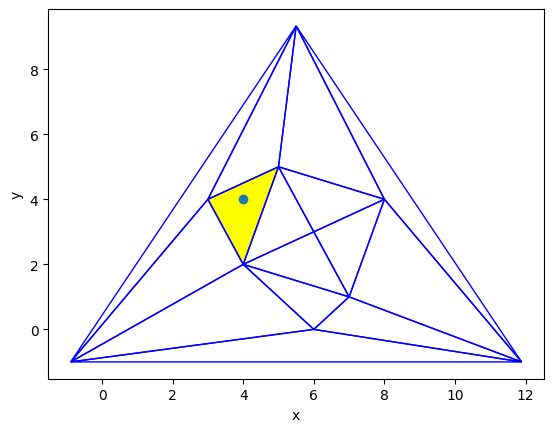

In [4]:

a = Kirkpatrick_with_vis(polygon_example_1)
a.preprocess()
a.query_with_show((4,4))

In [5]:
# a.show_prep()

In [6]:

# a.show_query()

In [7]:
t = {}
t["a"] = 1
print(t)
print(t["a"])

{'a': 1}
1


In [8]:
from scipy.spatial import Delaunay,delaunay_plot_2d
from planegeometry.structures.planarmaps import PlanarMap, Point, Segment, Triangle
from collections import deque
from typing import List
import mapbox_earcut as earcut
import numpy as np
from kirkpatrick_algorithm.visualizer.main import Visualizer

class Kirkpatrick_with_vis: 
    def __init__(self, polygon: List[tuple[float, float]]):
        self.vis = Visualizer()             #visualize gif
        self.polygon = polygon             #vis
        self.preprocess_steps = []
        self.dag_depth = {}
        self.vis_obj = {}
        self.to_add = []
        self.to_remove = []
        
        self.__original_polygon = polygon

        self.vis.add_point(polygon, color = "cyan")              #visualize gif

        outer_triangle = self.__add_outer_triangle(polygon)
        self.__polygon_with_triangle = self.__original_polygon + outer_triangle
        
        self.vis.add_point(outer_triangle, color = "orange")             #visualize gif
        # self.vis.add_point(outer_triangle, color = "white")             #visualize gif
        outer_triangle = [Point(x, y) for x, y in outer_triangle]

        self.__root_triangle = Triangle(outer_triangle[0], outer_triangle[1], outer_triangle[2])
        self.__outer_triangle = set(outer_triangle)

        self.__delaunay_triangulation = Delaunay(self.__polygon_with_triangle)
        self.__polygon_planar_map = self.__get_planar_map(self.__delaunay_triangulation)

        for seg in self.__polygon_planar_map.itersegments():
            self.vis_obj[seg] = self.vis.add_line_segment(((seg.pt1.x,seg.pt1.y),(seg.pt2.x,seg.pt2.y)))

        self.__preproccessed = False

        self.__triangles_graph = {}
        self.__triangles_list = []

        
    
    def __add_outer_triangle(self, polygon: List[tuple[float, float]]) -> List[tuple[float, float]]:
        min_x = min(polygon, key=lambda p: p[0])[0]
        max_x = max(polygon, key=lambda p: p[0])[0]
        min_y = min(polygon, key=lambda p: p[1])[1]
        max_y = max(polygon, key=lambda p: p[1])[1]

        a = (max_x - min_x)
        b = (max_y - min_y)

        min_x -= a*0.2
        max_x += a*0.2
        min_y -= b*0.2
        max_y += b*0.2

        sqrt_d = np.sqrt(4*a*a - 4*(a*a - 4/3*b*b))

        d = (2*a + sqrt_d)/2

        shift = (d - a)/2
        H = d*np.sqrt(3)/2
        

        return [(max_x + shift, min_y),(min_x - shift, min_y), ((max_x - min_x)/2 + min_x, H)]
    
    def __get_planar_map(self, delaunay: Delaunay) -> PlanarMap:
        set_of_edges = set()
        points = [Point(p[0], p[1]) for p in delaunay.points]

        get_edge = lambda a, b: (min(a, b), max(a, b))

        for a, b, c in delaunay.simplices:
            set_of_edges.add(get_edge(a, b))
            set_of_edges.add(get_edge(b, c))
            set_of_edges.add(get_edge(a, c))

        segments = [Segment(points[a], points[b]) for a, b in set_of_edges]

        dcel_map = PlanarMap(segments[0])
        for i in range(1, len(segments)):
            dcel_map.add_edge(segments[i])

        return dcel_map
    
    def __get_independent_set(self) -> List[Point]:
        visited = set()
        independent_set = []

        for point in self.__polygon_planar_map.iterpoints():
            if point not in visited and point not in self.__outer_triangle:
                independent_set.append(point)
                
                for adjacent_point in self.__polygon_planar_map.iteradjacent(point):
                    visited.add(adjacent_point)

        return independent_set
    
    def __remove_independent_set(self, indepndent_set: List[Point]) -> (List[List[Point]], int, List[List[Triangle]]):
        holes = []
        removed_triangles = []
        deleted_nodes = 0

        for independent_point in indepndent_set:
            if independent_point not in self.__outer_triangle:
                outedges = sorted(list(self.__polygon_planar_map.iteroutedges(independent_point)), key=lambda e: (e.target - e.source).alpha())
                holes.append([outedge.target for outedge in outedges])
                removed_triangles.append([])
                for i in range(len(holes[-1])):
                    removed_triangles[-1].append(Triangle(independent_point, holes[-1][i-1], holes[-1][i]))
                
                self.__polygon_planar_map.del_node(independent_point)
                deleted_nodes += 1

        return holes, deleted_nodes, removed_triangles
    
    def __triangle_intersect(self, t1: Triangle, t2: Triangle) -> bool:
        for t1_segment in t1.itersegments():
            for t2_segment in t2.itersegments():
                if t1_segment.intersect(t2_segment):
                    return True
                
        return False

    def preprocess(self):
        if self.__preproccessed:
            raise Exception("Already preproccessed")
        
        v = len(self.__polygon_with_triangle)

        for a, b, c in self.__delaunay_triangulation.simplices:
            triangle = Triangle(Point(self.__polygon_with_triangle[a][0], self.__polygon_with_triangle[a][1]),
                                Point(self.__polygon_with_triangle[b][0], self.__polygon_with_triangle[b][1]),
                                Point(self.__polygon_with_triangle[c][0], self.__polygon_with_triangle[c][1]))
            
            self.__triangles_list.append(triangle)
            self.__triangles_graph[triangle] = []
            self.dag_depth[triangle] = 0

        depth = 1
        while v > 3:
            print(self.__polygon_planar_map)
            print(all_removed_triangles)
            print(removed)

            independent_set = self.__get_independent_set()


            holes_points, removed, all_removed_triangles = self.__remove_independent_set(independent_set)
            v -= removed


            for hole_points, removed_triangles in zip(holes_points, all_removed_triangles):
                verts = np.array([[point.x, point.y] for point in hole_points]).reshape(-1, 2)
                rings = np.array([len(verts)])
                result = earcut.triangulate_float64(verts, rings)

                for a, b, c in result.reshape(-1,3):
                    new_triangle = Triangle(hole_points[a], hole_points[b], hole_points[c])

                    for segment in new_triangle.itersegments():
                        if not self.__polygon_planar_map.has_edge(segment):
                            self.__polygon_planar_map.add_edge(segment)

                    if not new_triangle in self.__triangles_graph:
                        self.__triangles_graph[new_triangle] = []
                        
                    for old_triangle in removed_triangles:
                        if self.__triangle_intersect(new_triangle, old_triangle):
                            self.__triangles_graph[new_triangle].append(old_triangle)
                            self.dag_depth[new_triangle] = depth
            depth += 1
        self.__preproccessed = True
    
    def get_triangles(self) -> List[Triangle]:
        return self.__triangles_list

    def query(self, point: (float, float)) -> Triangle:
        if not self.__preproccessed:
            raise Exception("Polygon is not preproccessed")
        
        point = Point(point[0], point[1])

        if not point in self.__root_triangle:
            return None
        
        current = self.__root_triangle

        self.is_used = [False for _ in range(len(self.query_steps))]

        while self.__triangles_graph[current]:
            for triangle in self.__triangles_graph[current]:
                if point in triangle:
                    current = triangle

                    i = self.dag_depth[triangle]
                    self.is_used[i] = True
                    vis = self.query_steps[i]
                    vis.add_polygon([(triangle.pt1.x, triangle.pt1.y), (triangle.pt2.x, triangle.pt2.y), (triangle.pt3.x, triangle.pt3.y)], color="yellow")
                    vis.add_point((point.x, point.y), color = "red")

                    break

        return current
    
    def query_with_show(self, point: (float, float)):
        vis = Visualizer()
        t = self.query(point)
        if t is not None:
            vis.add_polygon([(t.pt1.x, t.pt1.y), (t.pt2.x, t.pt2.y), (t.pt3.x, t.pt3.y)], color="yellow")
        
        vis.add_point(point, zorder=10)
        for t in self.__triangles_list:
            vis.add_polygon([(t.pt1.x, t.pt1.y), (t.pt2.x, t.pt2.y), (t.pt3.x, t.pt3.y)], fill=False, color="blue")

        vis.show()

    def add_points(self):
        self.vis.add_point(self.polygon)
        self.vis.add_point(self.ot)

    def visualize_gif(self):
        self.vis.show_gif(interval = 200)    


In [9]:
# a = Kirkpatrick_with_vis(polygon_example_1)

In [10]:
# a.visualize_gif()
# # a.vis.show()
# a.vis.show_gif()

In [26]:
import tkinter as tk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np

a = Kirkpatrick_with_vis(polygon_example_1)
a.preprocess()
a.query((4,4))
viss = a.preprocess_steps



root = tk.Tk()
global fig
global ax
fig, ax = viss[5].get_plot()
global i
i = 0
def plot():
    canvas.draw()
    
    i += 1
frame = tk.Frame(root)
label = tk.Label(text = "hello")
label.pack()

canvas = FigureCanvasTkAgg(fig, master = root)
canvas.get_tk_widget().pack()

frame.pack()
 
tk.Button(frame, text = "Plot", command = plot).pack(pady = 10)

root.mainloop()